In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(source_dir, train_dir, val_dir, split_ratio=0.7):
    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # Get all image files from the source directory
    images = os.listdir(source_dir)
    
    # Split images into training and validation sets
    train_images, val_images = train_test_split(images, train_size=split_ratio, random_state=42)
    
    # Copy images to their respective folders
    for img_name in train_images:
        shutil.copy(os.path.join(source_dir, img_name), os.path.join(train_dir, img_name))
        
    for img_name in val_images:
        shutil.copy(os.path.join(source_dir, img_name), os.path.join(val_dir, img_name))

# Define paths to each class folder
base_dir = "dataset"  # Replace with your base dataset directory

# Define paths for the training and validation directories
for category in ['damaged', 'red', 'green', 'yellow']:
    split_data(
        source_dir=os.path.join(base_dir, category),
        train_dir=os.path.join(base_dir, 'train', category),
        val_dir=os.path.join(base_dir, 'validation', category),
        split_ratio=0.7  # 70% train, 30% validation
    )

In [3]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import cv2  # OpenCV for webcam access

2024-12-15 14:24:28.637549: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 14:24:28.812682: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 14:24:28.982199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 14:24:29.135938: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 14:24:29.178642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 14:24:31.991202: W tensorflow/compiler/tf2tensorrt/utils/p

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'

# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Match the input size of your model
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),  # Match the input size of your model
    batch_size=32,
    class_mode='categorical'
)


Found 832 images belonging to 4 classes.
Found 357 images belonging to 4 classes.


In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization to prevent overfitting
predictions = Dense(4, activation='softmax')(x)
 
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_tomato_model.keras', save_best_only=True, monitor='val_accuracy')

In [10]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/5


/home/kuki/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-12-15 14:25:23.922514: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-12-15 14:25:25.945864: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-12-15 14:25:27.975173: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-12-15 14:25:30.420352: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-12-15 14:25:32.659420: W 

26/26 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.4657 - loss: 1.3515 - val_accuracy: 0.8599 - val_loss: 0.4393
Epoch 2/5


2024-12-15 14:27:27.398571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-12-15 14:27:35.209517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.8216 - loss: 0.4780 - val_accuracy: 0.8964 - val_loss: 0.2783
Epoch 3/5


2024-12-15 14:29:23.199718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-12-15 14:29:29.258156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.8696 - loss: 0.3270 - val_accuracy: 0.8936 - val_loss: 0.2746
Epoch 4/5


2024-12-15 14:31:18.066624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-12-15 14:31:25.592035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.8823 - loss: 0.3075 - val_accuracy: 0.9272 - val_loss: 0.2114
Epoch 5/5


2024-12-15 14:33:18.000476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-12-15 14:33:23.835863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.9251 - loss: 0.2439 - val_accuracy: 0.9272 - val_loss: 0.2083


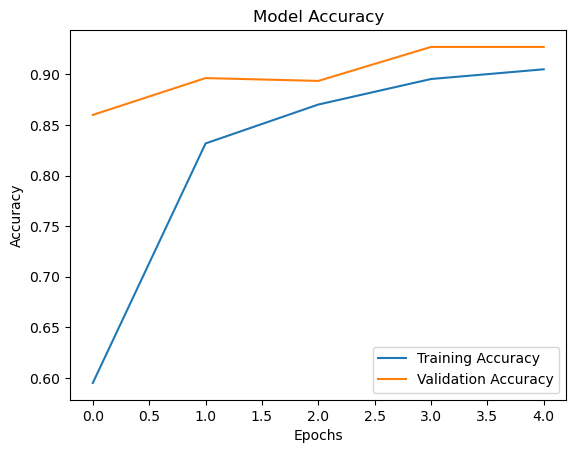

In [11]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

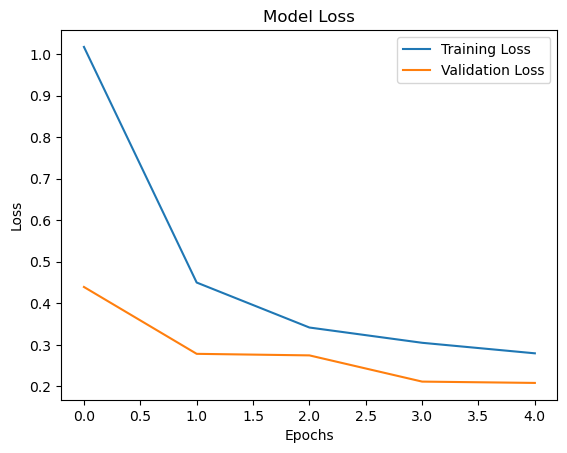

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.save('my_model.keras')